In [1]:
!ls -lah

total 624M
drwxr-xr-x  6 jovyan jovyan  192 Nov  8 10:58 .
drwxr-xr-x 37 jovyan jovyan 1.2K Nov  8 10:07 ..
drwxr-xr-x  4 jovyan jovyan  128 Nov  8 10:24 .ipynb_checkpoints
-rw-r--r--  1 jovyan jovyan 619M Nov  8 10:08 FOCI1.14-TEST.2020.04.1_1m_20110101_20111231_grid_T.nc
-rw-r--r--  1 jovyan jovyan 214K Nov  8 10:58 selection_01_no_dask.ipynb
-rw-r--r--  1 jovyan jovyan 216K Nov  8 10:57 selection_02_with_dask.ipynb


In [2]:
import xarray as xr
import numpy as np

In [3]:
np.random.seed(123)

In [4]:
ssh = xr.open_dataset("FOCI1.14-TEST.2020.04.1_1m_20110101_20111231_grid_T.nc").sossheig
ssh = ssh.assign_coords({"x": np.arange(ssh.shape[2]), "y": np.arange(ssh.shape[1])})
ssh

<xarray.DataArray 'sossheig' (time_counter: 12, y: 511, x: 722)>
[4427304 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 714 715 716 717 718 719 720 721
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 503 504 505 506 507 508 509 510
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  1800 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1800 s)

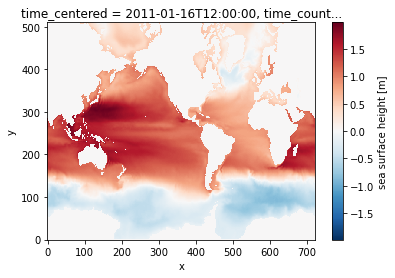

In [5]:
ssh.isel(time_counter=0).plot()

In [6]:
Nobs = 1_000_000

In [7]:
xs = xr.DataArray(
    np.random.uniform(0, 722, size=(Nobs, )),
    dims=("obs", ),
    name="x", 
)
ys = xr.DataArray(
    np.random.uniform(0, 511, size=(Nobs, )),
    dims=("obs", ),
    name="y", 
)
pos_xy = xr.Dataset(dict(x=xs, y=ys))
pos_xy

<xarray.Dataset>
Dimensions:  (obs: 1000000)
Dimensions without coordinates: obs
Data variables:
    x        (obs) float64 502.9 206.6 163.8 398.0 ... 583.7 475.0 330.6 322.6
    y        (obs) float64 394.8 238.7 10.19 471.9 ... 508.7 421.4 378.4 474.7

In [8]:
ssh.sel(x=pos_xy.x, y=pos_xy.y, method="nearest")

<xarray.DataArray 'sossheig' (time_counter: 12, obs: 1000000)>
[12000000 values with dtype=float32]
Coordinates:
    nav_lat        (obs) float32 ...
    nav_lon        (obs) float32 ...
    time_centered  (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
  * time_counter   (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
    x              (obs) int64 503 207 164 398 519 305 ... 590 584 475 331 323
    y              (obs) int64 395 239 10 472 92 112 ... 327 222 509 421 378 475
Dimensions without coordinates: obs
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  1800 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1800 s)

In [9]:
# %pip install xoak sklearn

In [10]:
lons = xr.DataArray(
    np.random.uniform(-180, 180, size=(Nobs, )),
    dims=("obs", ),
    name="lon", 
)
lats = xr.DataArray(
    np.random.uniform(-90, 90, size=(Nobs, )),
    dims=("obs", ),
    name="lat", 
)
pos = xr.Dataset(dict(lon=lons, lat=lats))
pos

<xarray.Dataset>
Dimensions:  (obs: 1000000)
Dimensions without coordinates: obs
Data variables:
    lon      (obs) float64 -19.74 1.887 -1.324 -2.027 ... -159.8 -66.15 -149.4
    lat      (obs) float64 82.05 78.18 -89.6 -51.1 ... -78.29 -11.95 -49.83

In [11]:
# This does not work, because `nav_lon` and `nav_lat` are 2d:
# ssh_at_pos = ssh.sel(nav_lon=pos.lon, nav_lat=pos.lat)
# ssh_at_pos

In [12]:
import xoak

In [13]:
ssh.xoak.set_index(['nav_lat', 'nav_lon'], 'sklearn_geo_balltree')

In [16]:
%%time

ssh_at_pos = ssh.xoak.sel(nav_lon=pos.lon, nav_lat=pos.lat)
ssh_at_pos

CPU times: user 28.9 s, sys: 201 ms, total: 29.1 s
Wall time: 29.2 s


<xarray.DataArray 'sossheig' (time_counter: 12, obs: 1000000)>
[12000000 values with dtype=float32]
Coordinates:
    nav_lat        (obs) float32 81.96 78.05 -77.01 ... -77.01 -11.91 -49.74
    nav_lon        (obs) float32 -19.12 2.139 -1.25 ... -159.8 -66.25 -149.2
    time_centered  (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
  * time_counter   (time_counter) datetime64[ns] 2011-01-16T12:00:00 ... 2011...
    x              (obs) int64 530 549 572 570 696 497 ... 431 227 255 442 276
    y              (obs) int64 474 462 0 130 84 297 ... 306 229 162 0 225 134
Dimensions without coordinates: obs
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  1800 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1800 s)

In [15]:
# (ssh_at_pos - ssh_at_pos.mean("time_counter")).plot()